
开始训练修正网络...
[Epoch 10] Loss: 0.000198
[Epoch 20] Loss: 0.000099
[Epoch 30] Loss: 0.000070
[Epoch 40] Loss: 0.000044
[Epoch 50] Loss: 0.000037
[Epoch 60] Loss: 0.000025
[Epoch 70] Loss: 0.000023
[Epoch 80] Loss: 0.000021
[Epoch 90] Loss: 0.000018
[Epoch 100] Loss: 0.000018
[Epoch 110] Loss: 0.000016
[Epoch 120] Loss: 0.000016
[Epoch 130] Loss: 0.000015
[Epoch 140] Loss: 0.000013
[Epoch 150] Loss: 0.000014
[Epoch 160] Loss: 0.000013
[Epoch 170] Loss: 0.000013
[Epoch 180] Loss: 0.000012
[Epoch 190] Loss: 0.000013
[Epoch 200] Loss: 0.000013

开始预测测试集...


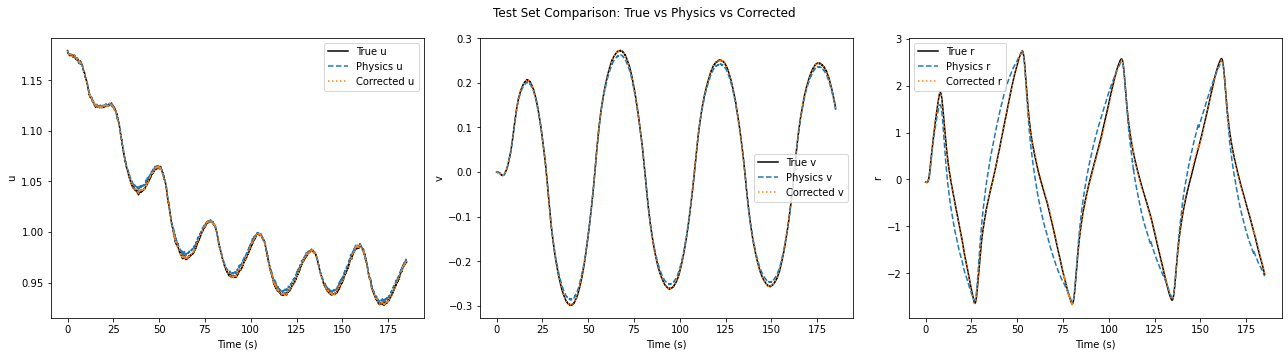

In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------
# ResidualAttentionNN 网络结构
# ----------------------------
class ResidualAttentionNN(nn.Module):
    def __init__(self, input_size=12, hidden_size=512, dropout_rate=0.3, num_heads=4):
        super(ResidualAttentionNN, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LayerNorm(hidden_size // 4),
            nn.SiLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )
        self.residual_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size // 16, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(hidden_size // 16, 3)

    def forward(self, x):
        base_out = self.base(x)
        residual = self.residual_layer(x)
        combined = base_out + residual
        attn_out, _ = self.attention(combined.unsqueeze(1), combined.unsqueeze(1), combined.unsqueeze(1))
        attn_out = attn_out.squeeze(1)
        combined = combined + attn_out
        return self.output_layer(combined)

# ----------------------------
# ShipMotionStatePINN 物理模型
# ----------------------------
class ShipMotionStatePINN(nn.Module):
    def __init__(self, vessel_params=None):
        super(ShipMotionStatePINN, self).__init__()
        self.vessel = vessel_params

    def compute_physics_derivatives(self, uvr, rudder, nps):
        """
        计算基于详细MMG物理模型的导数

        Args:
            uvr (torch.Tensor): 运动状态张量 [u, v, r]
            rudder (torch.Tensor): 舵角 (rad)
            nps (torch.Tensor): 螺旋桨转速 (RPS)

        Returns:
            torch.Tensor: 加速度导数 [du/dt, dv/dt, dr/dt]
        """
        batch_size = uvr.shape[0]
        u, v_m, r = uvr[:, 0], uvr[:, 1], uvr[:, 2]

        # 转换为合适的单位
        r_rad = torch.deg2rad(r)  # 角速度从deg/s转换为rad/s
        delta_rad = torch.deg2rad(rudder)  # 舵角从deg转换为rad
        nps_rps = nps  # RPM转换为RPS

        # 简写船舶参数
        p = self.vessel

        # 计算总速度和无量纲化参数
        U = torch.sqrt(u ** 2 + v_m ** 2)

        # 计算漂角和无量纲参数（添加小量避免除零）
        eps = 1e-6
        beta = torch.atan2(-v_m, u + eps)  # 漂角
        v_dash = v_m / (U + eps)  # 无量纲横向速度
        r_dash = r_rad * p['Lpp'] / (U + eps)  # 无量纲艏摇角速度

        # 螺旋桨伴流计算
        x_P_rel = -0.5  # 假设螺旋桨位置在船长的一半处
        beta_P = beta - (x_P_rel * r_dash)

        # 使用简化的w_P计算
        w_P = p['w_P0'] * torch.exp(-4.0 * beta_P ** 2)

        # 螺旋桨前进系数（添加小量避免除零）
        J = (1 - w_P) * u / (nps_rps * p['D_p'] + eps)

        # 螺旋桨推力系数
        K_T = -0.1476 * J ** 2 - 0.2219 * J + 0.3243

        # 舵参数计算
        beta_R = beta - p['l_R'] * r_dash

        # 流向整流系数
        gamma_R = torch.where(beta_R >= 0,
                              torch.tensor(p['gamma_R_plus'], dtype=beta_R.dtype, device=beta_R.device),
                              torch.tensor(p['gamma_R_minus'], dtype=beta_R.dtype, device=beta_R.device))

        # 舵入流速度
        v_R = U * gamma_R * beta_R

        # 考虑螺旋桨加速影响的舵入流速度
        u_R = u * (1 - w_P)

        # 更精确的螺旋桨-舵相互作用计算
        if p.get('epsilon') is not None and p.get('eta') is not None and p.get('kappa') is not None:
            term = torch.sqrt(1.0 + 8.0 * K_T / (torch.pi * J ** 2 + eps)) - 1
            u_R = u * (1 - w_P) * p['epsilon'] * torch.sqrt(
                p['eta'] * (1.0 + p['kappa'] * term) ** 2 + (1 - p['eta'])
            )

        # 舵入流总速度和角度
        U_R = torch.sqrt(u_R ** 2 + v_R ** 2)
        alpha_R = delta_rad - torch.atan2(v_R, u_R + eps)

        # 舵的法向力
        F_N = 0.5 * p['A_R'] * p['rho'] * \
              p['f_alpha'] * (U_R ** 2) * torch.sin(alpha_R)

        # 船体力
        X_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                -p['R_0_dash']
                + p['X_vv_dash'] * (v_dash ** 2)
                + p['X_vr_dash'] * v_dash * r_dash
                + p['X_rr_dash'] * (r_dash ** 2)
                + p.get('X_vvvv_dash', 0.0) * (v_dash ** 4)  # 如果没有设置则默认为0
        ))

        # 舵力
        X_R = -(1 - p['t_R']) * F_N * torch.sin(delta_rad)

        # 螺旋桨力
        X_P = (1 - p['t_P']) * p['rho'] * K_T * (nps_rps ** 2) * (p['D_p'] ** 4)

        # 横向船体力
        Y_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                p['Y_v_dash'] * v_dash
                + p['Y_r_dash'] * r_dash
                + p['Y_vvv_dash'] * (v_dash ** 3)
                + p['Y_vvr_dash'] * (v_dash ** 2) * r_dash
                + p.get('Y_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('Y_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 横向舵力
        Y_R = -(1 + p['a_H']) * F_N * torch.cos(delta_rad)

        # 艏摇力矩(船体)
        N_H = (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'] * (U ** 2) * (
                p['N_v_dash'] * v_dash
                + p['N_r_dash'] * r_dash
                + p['N_vvv_dash'] * (v_dash ** 3)
                + p.get('N_vvr_dash', 0.0) * (v_dash ** 2) * r_dash
                + p.get('N_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('N_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 艏摇力矩(舵)
        x_H = p['x_H_dash'] * p['Lpp']
        N_R = -(-0.5 * p['Lpp'] + p['a_H'] * x_H) * F_N * torch.cos(delta_rad)

        # 质量矩阵计算
        m_x = p['m_x_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        m_y = p['m_y_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        J_z = p['J_z_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 4) * p['d'])

        # 船舶质量和回转半径
        m = p['displ'] * p['rho']
        I_zG = m * (0.25 * p['Lpp']) ** 2

        # 构建质量矩阵 (批处理形式)
        zeros = torch.zeros(batch_size, device=u.device)
        ones = torch.ones(batch_size, device=u.device)

        # 刚体质量矩阵
        M_RB_11 = m * ones
        M_RB_22 = m * ones
        M_RB_23 = m * p['x_G'] * ones
        M_RB_32 = m * p['x_G'] * ones
        M_RB_33 = I_zG * ones

        # 附加质量矩阵
        M_A_11 = m_x * ones
        M_A_22 = m_y * ones
        M_A_33 = (J_z + (p['x_G'] ** 2) * m) * ones

        # 总质量矩阵对角元素
        M_11 = M_RB_11 + M_A_11
        M_22 = M_RB_22 + M_A_22
        M_33 = M_RB_33 + M_A_33

        # 总质量矩阵非对角元素
        M_23 = M_RB_23
        M_32 = M_RB_32

        # 科氏力和离心力项
        C_13 = -m * v_m
        C_23 = m * u
        C_31 = -m * v_m
        C_32 = m * u

        # 合力和力矩
        FX = X_H + X_R + X_P
        FY = Y_H + Y_R
        FN = N_H + N_R

        # 运动方程右侧项 (F - C*v)
        RHS_1 = FX - (-m * r_rad * v_m - m * p['x_G'] * r_rad ** 2)
        RHS_2 = FY - (m * r_rad * u)
        RHS_3 = FN - (m * p['x_G'] * r_rad * u)

        # 由于质量矩阵的耦合，我们需要计算完整的逆矩阵，这里采用简化处理
        # 考虑主要对角元素和一些关键的非对角元素
        det = M_11 * (M_22 * M_33 - M_23 * M_32)

        # 计算加速度 (考虑简化版本以避免复杂的批处理矩阵求逆)
        du_dt = RHS_1 / M_11
        dv_dt = (RHS_2 * M_33 - RHS_3 * M_23) / (M_22 * M_33 - M_23 * M_32)
        dr_dt = (RHS_3 * M_22 - RHS_2 * M_32) / (M_22 * M_33 - M_23 * M_32)

        # 将角速度从rad/s转回deg/s
        dr_dt = torch.rad2deg(dr_dt)

        # 组合导数
        derivatives = torch.stack([du_dt, dv_dt, dr_dt], dim=1)
        return derivatives

# ----------------------------
# 加载和预处理数据
# ----------------------------
folder_path = 'SIMMAN2008_backup'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z1505.csv']

inputs_train = []
next_states_train = []
ship_states_train = []
controls_train = []
dts_train = []

for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
    ship_states = data[['u', 'v', 'r']].values
    controls = data[['delta', 'n']].values
    times = data['time'].values

    for i in range(len(inputs) - 1):
        inputs_train.append(inputs[i])
        ship_states_train.append(ship_states[i])
        next_states_train.append(ship_states[i + 1])
        controls_train.append(controls[i])
        dts_train.append(times[i + 1] - times[i])

inputs_train = np.vstack(inputs_train)
ship_states_train = np.vstack(ship_states_train)
next_states_train = np.vstack(next_states_train)
controls_train = np.vstack(controls_train)
dts_train = np.array(dts_train)

# 读取测试集
test_data = pd.read_csv(os.path.join(folder_path, 'z1505.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
ship_states_test = test_data[['u', 'v', 'r']].values
controls_test = test_data[['delta', 'n']].values

# 标准化
input_scaler = StandardScaler()
inputs_train_scaled = input_scaler.fit_transform(inputs_train)
inputs_test_scaled = input_scaler.transform(inputs_test)

state_scaler = StandardScaler()
ship_states_train_scaled = state_scaler.fit_transform(ship_states_train)
next_states_train_scaled = state_scaler.fit_transform(next_states_train)
ship_states_test_scaled = state_scaler.transform(ship_states_test)

controls_train_scaled = controls_train
controls_test_scaled = controls_test

# 转换为tensor
X_train = torch.tensor(inputs_train_scaled, dtype=torch.float32)
states_train = torch.tensor(ship_states_train_scaled, dtype=torch.float32)
controls_train_tensor = torch.tensor(controls_train_scaled, dtype=torch.float32)

X_test = torch.tensor(inputs_test_scaled, dtype=torch.float32)
states_test = torch.tensor(ship_states_test_scaled, dtype=torch.float32)
controls_test_tensor = torch.tensor(controls_test_scaled, dtype=torch.float32)

# 构建DataLoader
train_dataset = TensorDataset(
    X_train, states_train, torch.tensor(next_states_train_scaled, dtype=torch.float32),
    controls_train_tensor, torch.tensor(dts_train, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ----------------------------
# 船舶参数
# ----------------------------
vessel_params = {
    'Lpp': 7.0,  # 船长 (m)
    'd': 0.455,  # 吃水 (m)
    'displ': 3.2724,  # 排水量 (t)
    'rho': 1030.0,  # 水密度 (kg/m³)
    'D_p': 0.204,  # 螺旋桨直径 (m)
    'x_P': -3.36,  # 螺旋桨位置 (m)
    'x_G': 0.244,  # 重心位置 (m)
    'x_H_dash': -0.464,  # 无因次化的横向力作用点
    'w_P0': 0.4,  # 螺旋桨伴流分数
    'gamma_R_plus': 0.640,  # 舵效率因子 (正漂角)
    'gamma_R_minus': 0.395,  # 舵效率因子 (负漂角)
    'l_R': -0.710,  # 舵位置比
    't_R': 0.387,  # 推力减额系数
    't_P': 0.220,  # 推力减额系数
    'epsilon': 1.09,  # 旋涡伴流系数
    'eta': 0.626,  # 螺旋桨效率
    'kappa': 0.50,  # 螺旋桨-船体相互作用系数
    'A_R': 0.0654,  # 舵面积与L*d之比
    'f_alpha': 2.747,  # 舵升力斜率
    'a_H': 0.312,  # 船体诱导升力系数

    # MMG模型系数 (无因次化)
    'R_0_dash': 0.022,
    'X_vv_dash': -0.040,
    'X_vr_dash': 0.002,
    'X_rr_dash': 0.011,
    'X_vvvv_dash': 0.771,

    'Y_v_dash': -0.315,
    'Y_r_dash': 0.083,
    'Y_vvv_dash': -1.607,
    'Y_vvr_dash': 0.379,
    'Y_vrr_dash': -0.391,
    'Y_rrr_dash': 0.008,

    'N_v_dash': -0.137,
    'N_r_dash': -0.049,
    'N_vvv_dash': -0.030,
    'N_vvr_dash': -0.294,
    'N_vrr_dash': 0.055,
    'N_rrr_dash': -0.013,

    # 附加质量系数 (无因次化)
    'm_x_dash': 0.022,
    'm_y_dash': 0.223,
    'J_z_dash': 0.011,
}

# ----------------------------
# 主训练函数
# ----------------------------
def train_correction_network(physics_model, correction_net, train_loader, optimizer, epochs=200):
    criterion = nn.SmoothL1Loss(beta=0.5)
    loss_history = []

    for epoch in range(epochs):
        physics_model.eval()
        correction_net.train()
        total_loss = 0.0

        for batch in train_loader:
            inputs_t, states_t, next_states_t, controls_t, dts = batch

            with torch.no_grad():
                physics_derivatives = physics_model.compute_physics_derivatives(
                    states_t, controls_t[:, 0], controls_t[:, 1]
                )
                states_phy = states_t + physics_derivatives * dts.unsqueeze(1)

            residual_input = torch.cat([inputs_t, states_phy, controls_t], dim=1)
            residual_correction = correction_net(residual_input)
            states_pred = states_phy + residual_correction

            loss = criterion(states_pred, next_states_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch + 1}] Loss: {avg_loss:.6f}")

    return loss_history

# ----------------------------
# 训练 & 预测可视化
# ----------------------------
def plot_comparison(time_array, true_states, phy_pred, final_pred, state_names):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Test Set Comparison: True vs Physics vs Corrected')

    for j in range(3):
        axs[j].plot(time_array, true_states[:, j], label=f'True {state_names[j]}', color='black')
        axs[j].plot(time_array, phy_pred[:, j], label=f'Physics {state_names[j]}', linestyle='--')
        axs[j].plot(time_array, final_pred[:, j], label=f'Corrected {state_names[j]}', linestyle=':')
        axs[j].set_xlabel('Time (s)')
        axs[j].set_ylabel(state_names[j])
        axs[j].legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 推理函数
# ----------------------------
def evaluate(physics_model, correction_net, X_test, states_test, controls_test_tensor, dt=0.05, state_scaler=None):
    physics_model.eval()
    correction_net.eval()
    with torch.no_grad():
        derivatives_test = physics_model.compute_physics_derivatives(
            states_test, controls_test_tensor[:, 0], controls_test_tensor[:, 1]
        )
        states_test_phy = states_test + derivatives_test * dt

        correction_input_test = torch.cat([
            X_test, states_test_phy, controls_test_tensor
        ], dim=1)
        correction_test = correction_net(correction_input_test)
        states_test_final = states_test_phy + correction_test

        if state_scaler is not None:
            states_test_final = state_scaler.inverse_transform(states_test_final.numpy())

        return states_test_final

# ----------------------------
# 启动训练与评估
# ----------------------------
if __name__ == '__main__':
    physics_model = ShipMotionStatePINN(vessel_params=vessel_params)
    correction_net = ResidualAttentionNN(input_size=12)
    optimizer = optim.AdamW(correction_net.parameters(), lr=0.001, weight_decay=5e-5)

    print("\n开始训练修正网络...")
    loss_history = train_correction_network(physics_model, correction_net, train_loader, optimizer, epochs=200)

    print("\n开始预测测试集...")
    with torch.no_grad():
        derivatives_test = physics_model.compute_physics_derivatives(
            states_test, controls_test_tensor[:, 0], controls_test_tensor[:, 1]
        )
        states_test_phy = states_test + derivatives_test * 0.05

        correction_input_test = torch.cat([
            X_test, states_test_phy, controls_test_tensor
        ], dim=1)
        correction_test = correction_net(correction_input_test)
        states_test_final = states_test_phy + correction_test

        states_test_true = state_scaler.inverse_transform(states_test.numpy())
        states_test_phy = state_scaler.inverse_transform(states_test_phy.numpy())
        states_test_final = state_scaler.inverse_transform(states_test_final.numpy())

        time_test = test_data['time'].values[:len(states_test_true)]
        plot_comparison(time_test, states_test_true, states_test_phy, states_test_final, state_names=['u', 'v', 'r'])




测试噪声水平: 2.0%
MSE: [2.4882205e-05 1.2990860e-04 1.0512485e-02]
RMSE: [0.00498821 0.01139775 0.10253041]
MAE: [0.00398339 0.00911239 0.08185702]
MAPE: [ 0.39763698 41.40933    65.54014   ]%


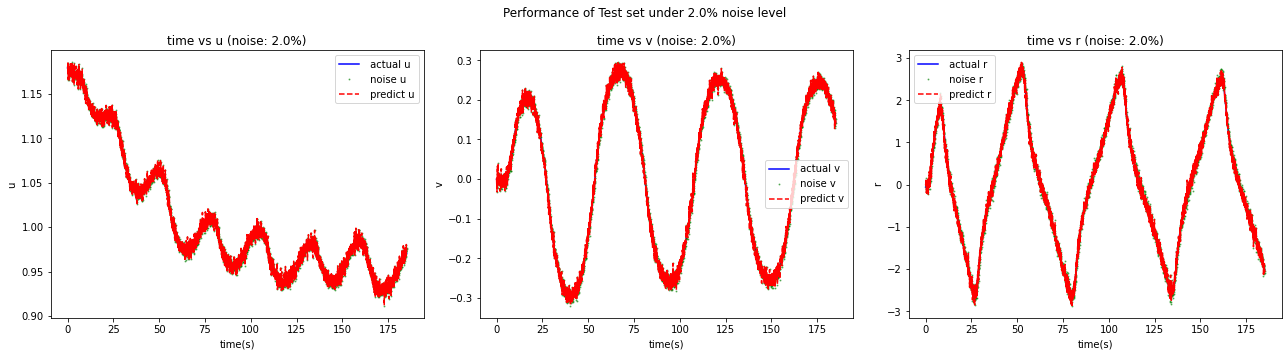


测试噪声水平: 3.0%
MSE: [5.6499066e-05 2.7367589e-04 2.2301266e-02]
RMSE: [0.00751659 0.01654315 0.14933608]
MAE: [0.00599381 0.01319732 0.11896986]
MAPE: [ 0.59817094 59.160976   77.82091   ]%


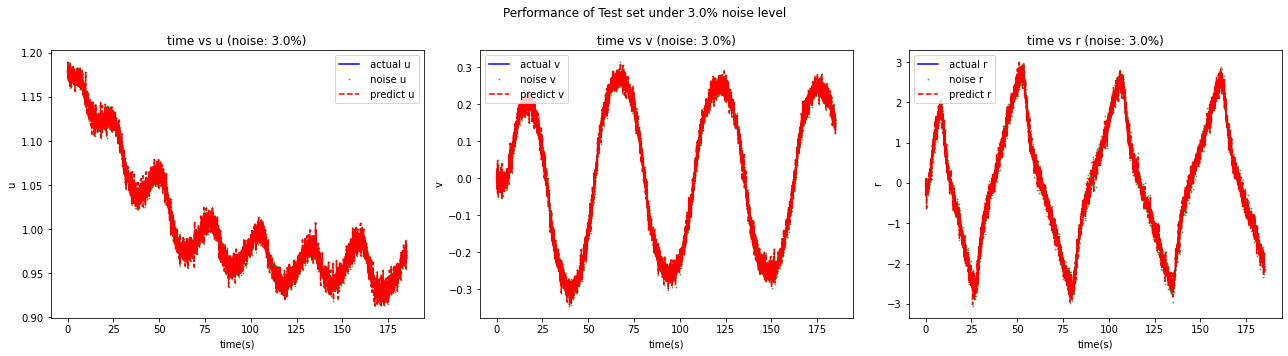


测试噪声水平: 4.0%
MSE: [0.00010058 0.00049314 0.04057586]
RMSE: [0.01002912 0.02220678 0.20143451]
MAE: [0.00798836 0.01780787 0.16138464]
MAPE: [  0.797843  78.54368  119.83823 ]%


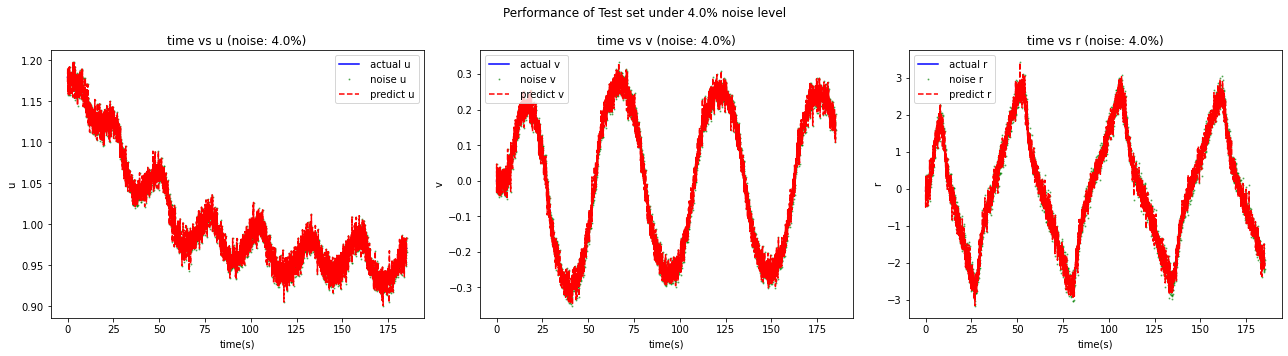


测试噪声水平: 5.0%
MSE: [0.0001593  0.00081597 0.06154646]
RMSE: [0.01262145 0.02856513 0.24808559]
MAE: [0.01006661 0.02263407 0.19763768]
MAPE: [  1.003022 100.71737  198.09068 ]%


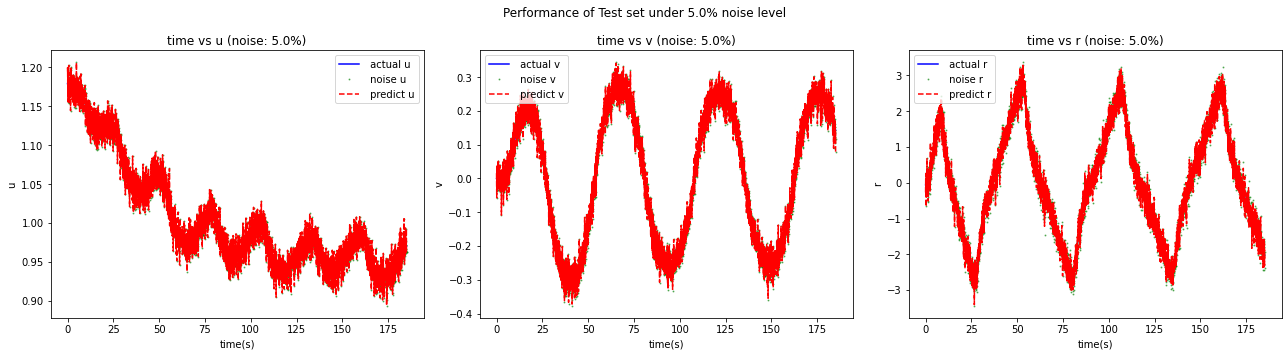

NameError: name 'plot_noise_performance_comparison' is not defined

In [5]:
def test_model_with_noise_for_PINN(
    physics_model, correction_net, X_test, ship_states_test, controls_test_tensor,
    state_scaler, test_time_array, noise_levels=[0.02, 0.03, 0.04, 0.05], dt=0.05
):
    correction_net.eval()
    physics_model.eval()
    results = {}

    original_states = state_scaler.inverse_transform(ship_states_test.numpy())

    signal_amplitudes = torch.tensor([
        torch.max(ship_states_test[:, i]) - torch.min(ship_states_test[:, i])
        for i in range(ship_states_test.shape[1])
    ])

    for noise_level in noise_levels:
        print(f"\n测试噪声水平: {noise_level*100:.1f}%")
        noise = torch.zeros_like(ship_states_test)
        for i in range(ship_states_test.shape[1]):
            noise[:, i] = torch.normal(
                mean=0, 
                std=noise_level * signal_amplitudes[i],
                size=ship_states_test[:, i].shape
            )

        noisy_states_test = ship_states_test + noise

        # === 推理流程：物理模型 → 残差修正网络 ===
        with torch.no_grad():
            derivatives = physics_model.compute_physics_derivatives(
                noisy_states_test, controls_test_tensor[:, 0], controls_test_tensor[:, 1]
            )
            states_phy = noisy_states_test + derivatives * dt

            correction_input = torch.cat([X_test, states_phy, controls_test_tensor], dim=1)
            correction = correction_net(correction_input)
            states_pred = states_phy + correction

            # 反标准化
            noisy_states_original = state_scaler.inverse_transform(noisy_states_test.numpy())
            states_pred_original = state_scaler.inverse_transform(states_pred.numpy())

        # === 误差指标 ===
        mse = np.mean((states_pred_original - original_states) ** 2, axis=0)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(states_pred_original - original_states), axis=0)
        epsilon = 1e-10
        mape = np.mean(np.abs((original_states - states_pred_original) / (np.abs(original_states) + epsilon)), axis=0) * 100

        results[noise_level] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'states_pred': states_pred_original,
            'noisy_states': noisy_states_original
        }

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}%")

        plot_prediction_with_noise(
            original_states,
            noisy_states_original,
            states_pred_original,
            test_time_array,
            noise_level
        )

    return results

noise_test_results = test_model_with_noise_for_PINN(
    physics_model,
    correction_net,
    X_test,
    states_test,
    controls_test_tensor,
    state_scaler,
    test_data['time'].values,
    noise_levels=[0.02, 0.03, 0.04, 0.05]
)


## 泛化能力测试


开始训练修正网络...
[Epoch 10] Loss: 0.000226
[Epoch 20] Loss: 0.000105
[Epoch 30] Loss: 0.000093
[Epoch 40] Loss: 0.000062
[Epoch 50] Loss: 0.000049
[Epoch 60] Loss: 0.000045
[Epoch 70] Loss: 0.000048
[Epoch 80] Loss: 0.000035
[Epoch 90] Loss: 0.000041
[Epoch 100] Loss: 0.000031
[Epoch 110] Loss: 0.000029
[Epoch 120] Loss: 0.000033
[Epoch 130] Loss: 0.000034
[Epoch 140] Loss: 0.000026
[Epoch 150] Loss: 0.000032
[Epoch 160] Loss: 0.000027
[Epoch 170] Loss: 0.000027
[Epoch 180] Loss: 0.000025
[Epoch 190] Loss: 0.000027
[Epoch 200] Loss: 0.000026

开始预测测试集...


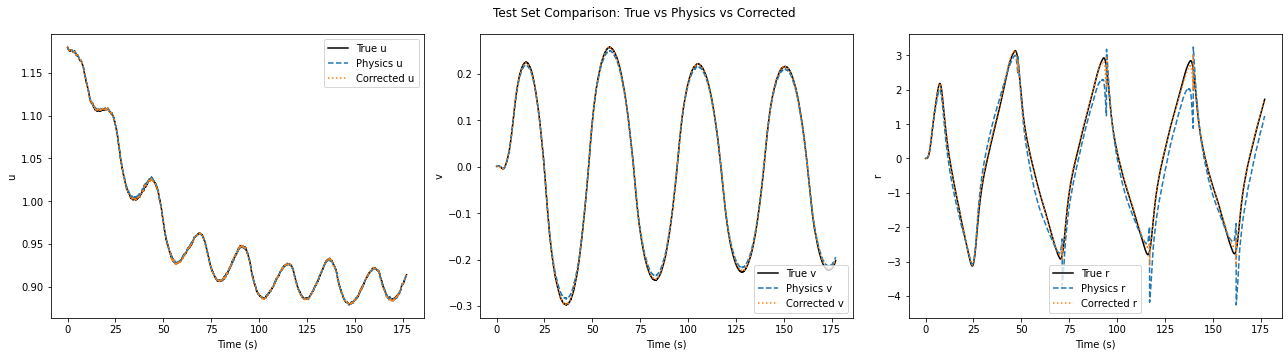

In [10]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------
# ResidualAttentionNN 网络结构
# ----------------------------
class ResidualAttentionNN(nn.Module):
    def __init__(self, input_size=12, hidden_size=512, dropout_rate=0.3, num_heads=4):
        super(ResidualAttentionNN, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.SiLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LayerNorm(hidden_size // 4),
            nn.SiLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )
        self.residual_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size // 8),
            nn.SiLU(),
            nn.Linear(hidden_size // 8, hidden_size // 16),
            nn.SiLU()
        )
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size // 16, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(hidden_size // 16, 3)

    def forward(self, x):
        base_out = self.base(x)
        residual = self.residual_layer(x)
        combined = base_out + residual
        attn_out, _ = self.attention(combined.unsqueeze(1), combined.unsqueeze(1), combined.unsqueeze(1))
        attn_out = attn_out.squeeze(1)
        combined = combined + attn_out
        return self.output_layer(combined)

# ----------------------------
# ShipMotionStatePINN 物理模型
# ----------------------------
class ShipMotionStatePINN(nn.Module):
    def __init__(self, vessel_params=None):
        super(ShipMotionStatePINN, self).__init__()
        self.vessel = vessel_params

    def compute_physics_derivatives(self, uvr, rudder, nps):
        """
        计算基于详细MMG物理模型的导数

        Args:
            uvr (torch.Tensor): 运动状态张量 [u, v, r]
            rudder (torch.Tensor): 舵角 (rad)
            nps (torch.Tensor): 螺旋桨转速 (RPS)

        Returns:
            torch.Tensor: 加速度导数 [du/dt, dv/dt, dr/dt]
        """
        batch_size = uvr.shape[0]
        u, v_m, r = uvr[:, 0], uvr[:, 1], uvr[:, 2]

        # 转换为合适的单位
        r_rad = torch.deg2rad(r)  # 角速度从deg/s转换为rad/s
        delta_rad = torch.deg2rad(rudder)  # 舵角从deg转换为rad
        nps_rps = nps  # RPM转换为RPS

        # 简写船舶参数
        p = self.vessel

        # 计算总速度和无量纲化参数
        U = torch.sqrt(u ** 2 + v_m ** 2)

        # 计算漂角和无量纲参数（添加小量避免除零）
        eps = 1e-6
        beta = torch.atan2(-v_m, u + eps)  # 漂角
        v_dash = v_m / (U + eps)  # 无量纲横向速度
        r_dash = r_rad * p['Lpp'] / (U + eps)  # 无量纲艏摇角速度

        # 螺旋桨伴流计算
        x_P_rel = -0.5  # 假设螺旋桨位置在船长的一半处
        beta_P = beta - (x_P_rel * r_dash)

        # 使用简化的w_P计算
        w_P = p['w_P0'] * torch.exp(-4.0 * beta_P ** 2)

        # 螺旋桨前进系数（添加小量避免除零）
        J = (1 - w_P) * u / (nps_rps * p['D_p'] + eps)

        # 螺旋桨推力系数
        K_T = -0.1476 * J ** 2 - 0.2219 * J + 0.3243

        # 舵参数计算
        beta_R = beta - p['l_R'] * r_dash

        # 流向整流系数
        gamma_R = torch.where(beta_R >= 0,
                              torch.tensor(p['gamma_R_plus'], dtype=beta_R.dtype, device=beta_R.device),
                              torch.tensor(p['gamma_R_minus'], dtype=beta_R.dtype, device=beta_R.device))

        # 舵入流速度
        v_R = U * gamma_R * beta_R

        # 考虑螺旋桨加速影响的舵入流速度
        u_R = u * (1 - w_P)

        # 更精确的螺旋桨-舵相互作用计算
        if p.get('epsilon') is not None and p.get('eta') is not None and p.get('kappa') is not None:
            term = torch.sqrt(1.0 + 8.0 * K_T / (torch.pi * J ** 2 + eps)) - 1
            u_R = u * (1 - w_P) * p['epsilon'] * torch.sqrt(
                p['eta'] * (1.0 + p['kappa'] * term) ** 2 + (1 - p['eta'])
            )

        # 舵入流总速度和角度
        U_R = torch.sqrt(u_R ** 2 + v_R ** 2)
        alpha_R = delta_rad - torch.atan2(v_R, u_R + eps)

        # 舵的法向力
        F_N = 0.5 * p['A_R'] * p['rho'] * \
              p['f_alpha'] * (U_R ** 2) * torch.sin(alpha_R)

        # 船体力
        X_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                -p['R_0_dash']
                + p['X_vv_dash'] * (v_dash ** 2)
                + p['X_vr_dash'] * v_dash * r_dash
                + p['X_rr_dash'] * (r_dash ** 2)
                + p.get('X_vvvv_dash', 0.0) * (v_dash ** 4)  # 如果没有设置则默认为0
        ))

        # 舵力
        X_R = -(1 - p['t_R']) * F_N * torch.sin(delta_rad)

        # 螺旋桨力
        X_P = (1 - p['t_P']) * p['rho'] * K_T * (nps_rps ** 2) * (p['D_p'] ** 4)

        # 横向船体力
        Y_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                p['Y_v_dash'] * v_dash
                + p['Y_r_dash'] * r_dash
                + p['Y_vvv_dash'] * (v_dash ** 3)
                + p['Y_vvr_dash'] * (v_dash ** 2) * r_dash
                + p.get('Y_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('Y_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 横向舵力
        Y_R = -(1 + p['a_H']) * F_N * torch.cos(delta_rad)

        # 艏摇力矩(船体)
        N_H = (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'] * (U ** 2) * (
                p['N_v_dash'] * v_dash
                + p['N_r_dash'] * r_dash
                + p['N_vvv_dash'] * (v_dash ** 3)
                + p.get('N_vvr_dash', 0.0) * (v_dash ** 2) * r_dash
                + p.get('N_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('N_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 艏摇力矩(舵)
        x_H = p['x_H_dash'] * p['Lpp']
        N_R = -(-0.5 * p['Lpp'] + p['a_H'] * x_H) * F_N * torch.cos(delta_rad)

        # 质量矩阵计算
        m_x = p['m_x_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        m_y = p['m_y_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        J_z = p['J_z_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 4) * p['d'])

        # 船舶质量和回转半径
        m = p['displ'] * p['rho']
        I_zG = m * (0.25 * p['Lpp']) ** 2

        # 构建质量矩阵 (批处理形式)
        zeros = torch.zeros(batch_size, device=u.device)
        ones = torch.ones(batch_size, device=u.device)

        # 刚体质量矩阵
        M_RB_11 = m * ones
        M_RB_22 = m * ones
        M_RB_23 = m * p['x_G'] * ones
        M_RB_32 = m * p['x_G'] * ones
        M_RB_33 = I_zG * ones

        # 附加质量矩阵
        M_A_11 = m_x * ones
        M_A_22 = m_y * ones
        M_A_33 = (J_z + (p['x_G'] ** 2) * m) * ones

        # 总质量矩阵对角元素
        M_11 = M_RB_11 + M_A_11
        M_22 = M_RB_22 + M_A_22
        M_33 = M_RB_33 + M_A_33

        # 总质量矩阵非对角元素
        M_23 = M_RB_23
        M_32 = M_RB_32

        # 科氏力和离心力项
        C_13 = -m * v_m
        C_23 = m * u
        C_31 = -m * v_m
        C_32 = m * u

        # 合力和力矩
        FX = X_H + X_R + X_P
        FY = Y_H + Y_R
        FN = N_H + N_R

        # 运动方程右侧项 (F - C*v)
        RHS_1 = FX - (-m * r_rad * v_m - m * p['x_G'] * r_rad ** 2)
        RHS_2 = FY - (m * r_rad * u)
        RHS_3 = FN - (m * p['x_G'] * r_rad * u)

        # 由于质量矩阵的耦合，我们需要计算完整的逆矩阵，这里采用简化处理
        # 考虑主要对角元素和一些关键的非对角元素
        det = M_11 * (M_22 * M_33 - M_23 * M_32)

        # 计算加速度 (考虑简化版本以避免复杂的批处理矩阵求逆)
        du_dt = RHS_1 / M_11
        dv_dt = (RHS_2 * M_33 - RHS_3 * M_23) / (M_22 * M_33 - M_23 * M_32)
        dr_dt = (RHS_3 * M_22 - RHS_2 * M_32) / (M_22 * M_33 - M_23 * M_32)

        # 将角速度从rad/s转回deg/s
        dr_dt = torch.rad2deg(dr_dt)

        # 组合导数
        derivatives = torch.stack([du_dt, dv_dt, dr_dt], dim=1)
        return derivatives

# ----------------------------
# 加载和预处理数据
# ----------------------------
folder_path = 'SIMMAN2008'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z2005.csv']

inputs_train = []
next_states_train = []
ship_states_train = []
controls_train = []
dts_train = []

for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
    ship_states = data[['u', 'v', 'r']].values
    controls = data[['delta', 'n']].values
    times = data['time'].values

    for i in range(len(inputs) - 1):
        inputs_train.append(inputs[i])
        ship_states_train.append(ship_states[i])
        next_states_train.append(ship_states[i + 1])
        controls_train.append(controls[i])
        dts_train.append(times[i + 1] - times[i])

inputs_train = np.vstack(inputs_train)
ship_states_train = np.vstack(ship_states_train)
next_states_train = np.vstack(next_states_train)
controls_train = np.vstack(controls_train)
dts_train = np.array(dts_train)

# 读取测试集
test_data = pd.read_csv(os.path.join(folder_path, 'z2005.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
ship_states_test = test_data[['u', 'v', 'r']].values
controls_test = test_data[['delta', 'n']].values

# 标准化
input_scaler = StandardScaler()
inputs_train_scaled = input_scaler.fit_transform(inputs_train)
inputs_test_scaled = input_scaler.transform(inputs_test)

state_scaler = StandardScaler()
ship_states_train_scaled = state_scaler.fit_transform(ship_states_train)
next_states_train_scaled = state_scaler.fit_transform(next_states_train)
ship_states_test_scaled = state_scaler.transform(ship_states_test)

controls_train_scaled = controls_train
controls_test_scaled = controls_test

# 转换为tensor
X_train = torch.tensor(inputs_train_scaled, dtype=torch.float32)
states_train = torch.tensor(ship_states_train_scaled, dtype=torch.float32)
controls_train_tensor = torch.tensor(controls_train_scaled, dtype=torch.float32)

X_test = torch.tensor(inputs_test_scaled, dtype=torch.float32)
states_test = torch.tensor(ship_states_test_scaled, dtype=torch.float32)
controls_test_tensor = torch.tensor(controls_test_scaled, dtype=torch.float32)

# 构建DataLoader
train_dataset = TensorDataset(
    X_train, states_train, torch.tensor(next_states_train_scaled, dtype=torch.float32),
    controls_train_tensor, torch.tensor(dts_train, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ----------------------------
# 船舶参数
# ----------------------------
vessel_params = {
    'Lpp': 7.0,  # 船长 (m)
    'd': 0.455,  # 吃水 (m)
    'displ': 3.2724,  # 排水量 (t)
    'rho': 1030.0,  # 水密度 (kg/m³)
    'D_p': 0.204,  # 螺旋桨直径 (m)
    'x_P': -3.36,  # 螺旋桨位置 (m)
    'x_G': 0.244,  # 重心位置 (m)
    'x_H_dash': -0.464,  # 无因次化的横向力作用点
    'w_P0': 0.4,  # 螺旋桨伴流分数
    'gamma_R_plus': 0.640,  # 舵效率因子 (正漂角)
    'gamma_R_minus': 0.395,  # 舵效率因子 (负漂角)
    'l_R': -0.710,  # 舵位置比
    't_R': 0.387,  # 推力减额系数
    't_P': 0.220,  # 推力减额系数
    'epsilon': 1.09,  # 旋涡伴流系数
    'eta': 0.626,  # 螺旋桨效率
    'kappa': 0.50,  # 螺旋桨-船体相互作用系数
    'A_R': 0.0654,  # 舵面积与L*d之比
    'f_alpha': 2.747,  # 舵升力斜率
    'a_H': 0.312,  # 船体诱导升力系数

    # MMG模型系数 (无因次化)
    'R_0_dash': 0.022,
    'X_vv_dash': -0.040,
    'X_vr_dash': 0.002,
    'X_rr_dash': 0.011,
    'X_vvvv_dash': 0.771,

    'Y_v_dash': -0.315,
    'Y_r_dash': 0.083,
    'Y_vvv_dash': -1.607,
    'Y_vvr_dash': 0.379,
    'Y_vrr_dash': -0.391,
    'Y_rrr_dash': 0.008,

    'N_v_dash': -0.137,
    'N_r_dash': -0.049,
    'N_vvv_dash': -0.030,
    'N_vvr_dash': -0.294,
    'N_vrr_dash': 0.055,
    'N_rrr_dash': -0.013,

    # 附加质量系数 (无因次化)
    'm_x_dash': 0.022,
    'm_y_dash': 0.223,
    'J_z_dash': 0.011,
}

# ----------------------------
# 主训练函数
# ----------------------------
def train_correction_network(physics_model, correction_net, train_loader, optimizer, epochs=200):
    criterion = nn.SmoothL1Loss(beta=0.5)
    loss_history = []

    for epoch in range(epochs):
        physics_model.eval()
        correction_net.train()
        total_loss = 0.0

        for batch in train_loader:
            inputs_t, states_t, next_states_t, controls_t, dts = batch

            with torch.no_grad():
                physics_derivatives = physics_model.compute_physics_derivatives(
                    states_t, controls_t[:, 0], controls_t[:, 1]
                )
                states_phy = states_t + physics_derivatives * dts.unsqueeze(1)

            residual_input = torch.cat([inputs_t, states_phy, controls_t], dim=1)
            residual_correction = correction_net(residual_input)
            states_pred = states_phy + residual_correction

            loss = criterion(states_pred, next_states_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch + 1}] Loss: {avg_loss:.6f}")

    return loss_history

# ----------------------------
# 训练 & 预测可视化
# ----------------------------
def plot_comparison(time_array, true_states, phy_pred, final_pred, state_names):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Test Set Comparison: True vs Physics vs Corrected')

    for j in range(3):
        axs[j].plot(time_array, true_states[:, j], label=f'True {state_names[j]}', color='black')
        axs[j].plot(time_array, phy_pred[:, j], label=f'Physics {state_names[j]}', linestyle='--')
        axs[j].plot(time_array, final_pred[:, j], label=f'Corrected {state_names[j]}', linestyle=':')
        axs[j].set_xlabel('Time (s)')
        axs[j].set_ylabel(state_names[j])
        axs[j].legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 推理函数
# ----------------------------
def evaluate(physics_model, correction_net, X_test, states_test, controls_test_tensor, dt=0.05, state_scaler=None):
    physics_model.eval()
    correction_net.eval()
    with torch.no_grad():
        derivatives_test = physics_model.compute_physics_derivatives(
            states_test, controls_test_tensor[:, 0], controls_test_tensor[:, 1]
        )
        states_test_phy = states_test + derivatives_test * dt

        correction_input_test = torch.cat([
            X_test, states_test_phy, controls_test_tensor
        ], dim=1)
        correction_test = correction_net(correction_input_test)
        states_test_final = states_test_phy + correction_test

        if state_scaler is not None:
            states_test_final = state_scaler.inverse_transform(states_test_final.numpy())

        return states_test_final

# ----------------------------
# 启动训练与评估
# ----------------------------
if __name__ == '__main__':
    physics_model = ShipMotionStatePINN(vessel_params=vessel_params)
    correction_net = ResidualAttentionNN(input_size=12)
    optimizer = optim.AdamW(correction_net.parameters(), lr=0.001, weight_decay=5e-5)

    print("\n开始训练修正网络...")
    loss_history = train_correction_network(physics_model, correction_net, train_loader, optimizer, epochs=200)

    print("\n开始预测测试集...")
    with torch.no_grad():
        derivatives_test = physics_model.compute_physics_derivatives(
            states_test, controls_test_tensor[:, 0], controls_test_tensor[:, 1]
        )
        states_test_phy = states_test + derivatives_test * 0.05

        correction_input_test = torch.cat([
            X_test, states_test_phy, controls_test_tensor
        ], dim=1)
        correction_test = correction_net(correction_input_test)
        states_test_final = states_test_phy + correction_test

        states_test_true = state_scaler.inverse_transform(states_test.numpy())
        states_test_phy = state_scaler.inverse_transform(states_test_phy.numpy())
        states_test_final = state_scaler.inverse_transform(states_test_final.numpy())

        time_test = test_data['time'].values[:len(states_test_true)]
        plot_comparison(time_test, states_test_true, states_test_phy, states_test_final, state_names=['u', 'v', 'r'])

